In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import seaborn as sns

sns.set_style("whitegrid")

# Przygotowywanie danych
Załadujemy zbiór danych MNIST i wydzielimy ze zbioru treningowego zbiór walidacyjny.

In [2]:
mnist_train_and_val = MNIST(".", train=True, download=True, transform=ToTensor())
mnist_train = Subset(mnist_train_and_val, list(range(50000)))
mnist_val = Subset(mnist_train_and_val, list(range(50000, 60000)))
mnist_test = MNIST(".", train=False, download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/home/wolczyk/miniconda3/envs/pytorch1.9/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Wizualizacja zbioru danych

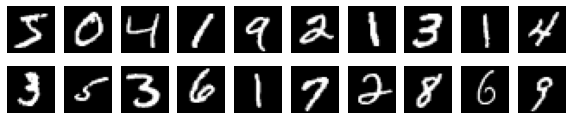

In [3]:
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
axes = axes.ravel()

for idx in range(20):
    axes[idx].imshow(mnist_train[idx][0].squeeze(), cmap="gray")
    axes[idx].axis("off")
fig.show()

# Metoda spadku gradientu

Poniżej definiujemy metodę spadku gradientu w wersji nie stochastycznej - to znaczy, że będziemy liczyć gradient korzystając z całego zbioru treningowego.

In [4]:
@torch.no_grad()
def evaluate_fullgd(model, x, y):
    # Full batch version
    total_num = 0
    correct_num = 0
    
    preds = model(x)
    correct_num += (y == preds.argmax(-1)).float().sum().item()
    total_num += len(y)
    return correct_num / total_num


def train_fullgd(lr, bs, epochs_num):
    
    # Definicja modelu
    model = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    model = model.cuda()
    
    print("=" * 5, f"{lr=}", "=" * 5)
    train_loader = DataLoader(mnist_train, batch_size=bs, shuffle=False if bs == 50000 else True)
    val_loader = DataLoader(mnist_val, batch_size=bs, shuffle=False)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    train_accs = []
    val_accs = []
    
    # Full batch version
    x, y = next(iter(train_loader))
    x = x.cuda().view(-1, 784)
    y = y.cuda()
    
    x_val, y_val = next(iter(val_loader))
    x_val = x_val.cuda().view(-1, 784)
    y_val = y_val.cuda()
    
    for epoch in range(epochs_num):
        epoch_loss = []
        preds = model(x)
        loss_val = loss_fn(preds, y)
        loss_val.backward()
        epoch_loss += [loss_val.item()]
        optimizer.step()
        optimizer.zero_grad()
        
        train_losses += [np.mean(epoch_loss)]
        train_acc = (preds.argmax(-1) == y).float().mean().item()
        train_accs += [train_acc]

        val_acc = evaluate_fullgd(model, x_val, y_val)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, val acc: {val_acc}")
        val_accs += [val_acc]
    return train_losses, train_accs, val_accs


Przetestujmy działanie modelu dla kilku różnych wartości kroku uczenia.

In [5]:
lr_dict = {}
for lr in [0.001, 0.01, 0.1, 1.0]:
    lr_dict[lr] = train_fullgd(lr, bs=50000, epochs_num=1000)

===== lr=0.001 =====
Epoch: 0, val acc: 0.0947
Epoch: 100, val acc: 0.0997
Epoch: 200, val acc: 0.1041
Epoch: 300, val acc: 0.1079
Epoch: 400, val acc: 0.1138
Epoch: 500, val acc: 0.1208
Epoch: 600, val acc: 0.1267
Epoch: 700, val acc: 0.1354
Epoch: 800, val acc: 0.1445
Epoch: 900, val acc: 0.1535
===== lr=0.01 =====
Epoch: 0, val acc: 0.0964
Epoch: 100, val acc: 0.1003
Epoch: 200, val acc: 0.1005
Epoch: 300, val acc: 0.1291
Epoch: 400, val acc: 0.267
Epoch: 500, val acc: 0.3586
Epoch: 600, val acc: 0.4766
Epoch: 700, val acc: 0.4888
Epoch: 800, val acc: 0.4659
Epoch: 900, val acc: 0.4822
===== lr=0.1 =====
Epoch: 0, val acc: 0.1255
Epoch: 100, val acc: 0.5397
Epoch: 200, val acc: 0.7827
Epoch: 300, val acc: 0.9022
Epoch: 400, val acc: 0.9137
Epoch: 500, val acc: 0.9186
Epoch: 600, val acc: 0.93
Epoch: 700, val acc: 0.9361
Epoch: 800, val acc: 0.9408
Epoch: 900, val acc: 0.9467
===== lr=1.0 =====
Epoch: 0, val acc: 0.099
Epoch: 100, val acc: 0.2392
Epoch: 200, val acc: 0.5951
Epoch: 30

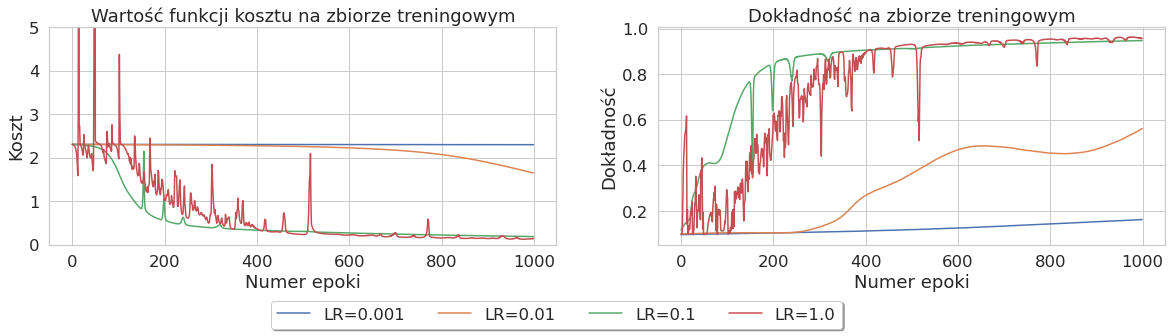

In [6]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20, 4))
loss_ax.set_title("Wartość funkcji kosztu na zbiorze treningowym")
loss_ax.set_xlabel("Numer epoki")
loss_ax.set_ylabel("Koszt")
loss_ax.set_ylim(0, 5)

acc_ax.set_title("Dokładność na zbiorze treningowym")
acc_ax.set_xlabel("Numer epoki")
acc_ax.set_ylabel("Dokładność")

for lr, results in lr_dict.items():
    loss_ax.plot(results[0], label=f"LR={lr}")
    loss_ax.legend(
        loc="upper center",
        bbox_to_anchor=(1.0, -0.22),
        fancybox=True,
        shadow=True,
        ncol=5,
    )
    acc_ax.plot(results[1], label=f"LR={lr}")

# Metoda stochastycznego spadku gradientu

Zdefinujmy teraz SGD - czyli wersję spadku gradientu, w której gradient będzie liczony tylko po podzbiorze (tzw. batchu) całego zbioru treningowego.

In [7]:
def train_sgd(lr, bs, epochs_num):
    model = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    model = model.cuda()
    
    print("=" * 5, f"{lr=}", f"{bs=}", "=" * 5)
    train_loader = DataLoader(
        mnist_train, batch_size=bs,
        pin_memory=True, num_workers=5,
    )
    val_loader = DataLoader(mnist_val, batch_size=50000, shuffle=False)
    x_val, y_val = next(iter(val_loader))
    x_val = x_val.cuda().view(-1, 784)
    y_val = y_val.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    train_accs = []
    val_accs = []
    
    # Full batch version
    
    for epoch in range(epochs_num):
        
        epoch_loss = []
        correct_num = 0
        total_num = 0
        for x, y in train_loader:
            x = x.cuda().view(-1, 784)
            y = y.cuda()
            preds = model(x)
            loss_val = loss_fn(preds, y)
            loss_val.backward()
            epoch_loss += [loss_val.item()]
            optimizer.step()
            optimizer.zero_grad()
            correct_num += (preds.argmax(-1) == y).float().sum().item()
            total_num += len(x)
        train_accs += [correct_num / total_num]
        train_losses += [np.mean(epoch_loss)]

        val_acc = evaluate_fullgd(model, x_val, y_val)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, train loss: {np.mean(epoch_loss)}, val acc: {val_acc}")
        val_accs += [val_acc]
    return train_losses, train_accs, val_accs

Przetestujmy tym razem modele z różnymi wielkościami batcha.

In [9]:
bs_dict = {}
for bs in [16, 32, 64, 128, 256, 512, 1024]:
    bs_dict[bs] = train_sgd(1e-1, bs, 100)

===== lr=0.1 bs=16 =====
Epoch 0, train loss: 0.34732225506149234, val acc: 0.957
===== lr=0.1 bs=32 =====
Epoch 0, train loss: 0.47830833036092635, val acc: 0.9474
===== lr=0.1 bs=64 =====
Epoch 0, train loss: 0.6855469748015751, val acc: 0.9159
===== lr=0.1 bs=128 =====
Epoch 0, train loss: 1.1399425492643396, val acc: 0.8851
===== lr=0.1 bs=256 =====
Epoch 0, train loss: 1.6477179499913235, val acc: 0.8001
===== lr=0.1 bs=512 =====
Epoch 0, train loss: 2.2126908788875657, val acc: 0.5578
===== lr=0.1 bs=1024 =====
Epoch 0, train loss: 2.2871288572038924, val acc: 0.3723


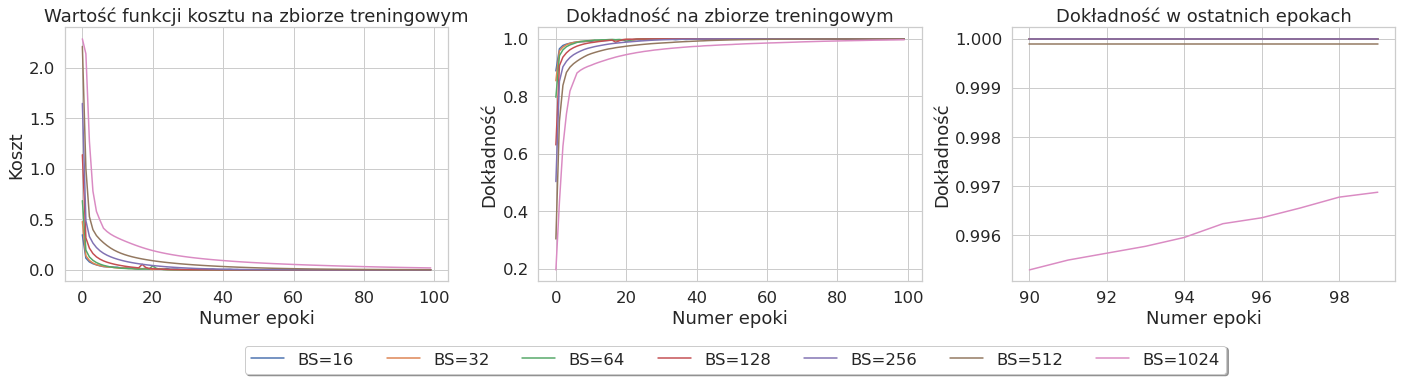

In [10]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
fig, (loss_ax, acc_ax, zoomed_acc_ax) = plt.subplots(1, 3, figsize=(20, 5))
loss_ax.set_title("Wartość funkcji kosztu na zbiorze treningowym")
loss_ax.set_xlabel("Numer epoki")
loss_ax.set_ylabel("Koszt")

acc_ax.set_title("Dokładność na zbiorze treningowym")
acc_ax.set_xlabel("Numer epoki")
acc_ax.set_ylabel("Dokładność")

zoomed_acc_ax.set_title("Dokładność w ostatnich epokach")
zoomed_acc_ax.set_xlabel("Numer epoki")
zoomed_acc_ax.set_ylabel("Dokładność")

plt.tight_layout()
for bs, results in bs_dict.items():
    x = results[0]
    loss_ax.plot(results[0], label=f"BS={bs}")
    loss_ax.legend(
        loc="upper center",
        bbox_to_anchor=(1.75, -0.22),
        fancybox=True,
        shadow=True,
        ncol=7,
    )
    acc_ax.plot(results[1], label=f"BS={bs}")
    zoomed_acc_ax.plot(np.arange(90, 100), results[1][-10:], label=f"BS={bs}")

# Różne optymalizatory

Porównamy teraz ze sobą różne optymalizatory - SGD, Momentum oraz Adam.

In [11]:
def train_optimizers(bs, epochs_num, optim_cls, optim_kwargs):
    model = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
    )
    model = model.cuda()

    train_loader = DataLoader(
        mnist_train,
        batch_size=bs,
        pin_memory=True,
        num_workers=4,
    )
    val_loader = DataLoader(mnist_val, batch_size=50000, shuffle=False)
    x_val, y_val = next(iter(val_loader))
    x_val = x_val.cuda().view(-1, 784)
    y_val = y_val.cuda()

    optimizer = optim_cls(model.parameters(), **optim_kwargs)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs_num):

        epoch_loss = []
        correct_num = 0
        total_num = 0
        for x, y in train_loader:
            x = x.cuda().view(-1, 784)
            y = y.cuda()
            preds = model(x)
            loss_val = loss_fn(preds, y)
            loss_val.backward()
            epoch_loss += [loss_val.item()]
            optimizer.step()
            optimizer.zero_grad()
            correct_num += (preds.argmax(-1) == y).float().sum().item()
            total_num += len(x)
        train_accs += [correct_num / total_num]
        train_losses += [np.mean(epoch_loss)]

        val_acc = evaluate_fullgd(model, x_val, y_val)
        if epoch % 100 == 0:
            print(
                f"Epoch {epoch}, train loss: {np.mean(epoch_loss)}, val acc: {val_acc}"
            )
        val_accs += [val_acc]
    return train_losses, train_accs, val_accs

In [28]:
optim_results = {}
optim_results["SGD"] = train_optimizers(128, 100, torch.optim.SGD, {"lr": 0.1})
optim_results["Momentum"] = train_optimizers(
    128, 100, torch.optim.SGD, {"lr": 0.1, "momentum": 0.9}
)
optim_results["Adam"] = train_optimizers(128, 100, torch.optim.Adam, {"lr": 0.001})

Epoch 0, train loss: 1.0450092879555108, val acc: 0.8895
Epoch 0, train loss: 0.5001208521711552, val acc: 0.9539
Epoch 0, train loss: 0.47768780968302044, val acc: 0.9444


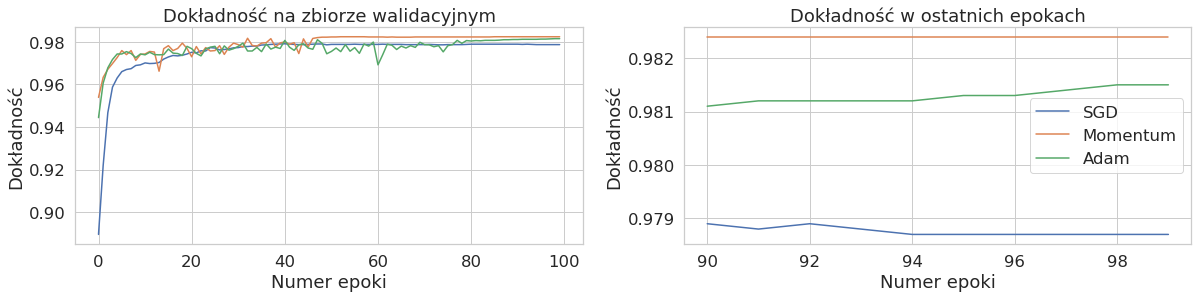

In [30]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

fig, (acc_ax, zoomed_acc_ax) = plt.subplots(1, 2, figsize=(20, 4))

acc_ax.set_title("Dokładność na zbiorze walidacyjnym")
acc_ax.set_xlabel("Numer epoki")
acc_ax.set_ylabel("Dokładność")

zoomed_acc_ax.set_title("Dokładność w ostatnich epokach")
zoomed_acc_ax.set_xlabel("Numer epoki")
zoomed_acc_ax.set_ylabel("Dokładność")

for key, results in optim_results.items():
    # loss_ax.plot(results[0], label=name)
    acc_ax.plot(results[2], label=key)
    zoomed_acc_ax.plot(np.arange(90, 100), results[2][90:], label=key)
    zoomed_acc_ax.legend()
    zoomed_acc_ax.set_yticks([0.979, 0.980, 0.981, 0.982])
plt.show()